# Nearest Neighbours - Synthetic Dataset (LR0)

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.171413,0.157335,0.185269,0.216191,0.243991,0.266050,0.285464,0.301123,0.314039,0.328453,0.341520,0.356677,0.372592,0.389141,0.407686,0.424694,0.443750,0.461699,0.478928,0.495170
Validation Score RMSE,0.246486,0.222493,0.261476,0.303024,0.336492,0.364335,0.386914,0.406908,0.423459,0.440271,0.455002,0.468627,0.483773,0.500295,0.517165,0.533140,0.551164,0.569266,0.586735,0.604679
Validation Score MAPE,0.786588,0.788193,0.993470,1.075727,1.240507,1.362283,1.603381,1.733756,1.879956,1.948718,2.025865,2.127920,2.188020,2.275314,2.365456,2.442276,2.538030,2.628672,2.703820,2.815679
Validation Score R Squared,0.925348,0.939174,0.915992,0.887173,0.860874,0.836898,0.816055,0.796553,0.779666,0.761824,0.745618,0.730155,0.712431,0.692454,0.671363,0.650747,0.626733,0.601812,0.576998,0.550729


The smallest Validation Score MAE is 0.15733451387842134, found in K = 4.
The smallest Validation Score RMSE is 0.22249265907828794, found in K = 4.
The smallest Validation Score MAPE is 0.7865881282317069, found in K = 1.
The largest Validation Score R Squared is 0.939173913097694, found in K = 4.
Validation Computation Time: 0.20 seconds


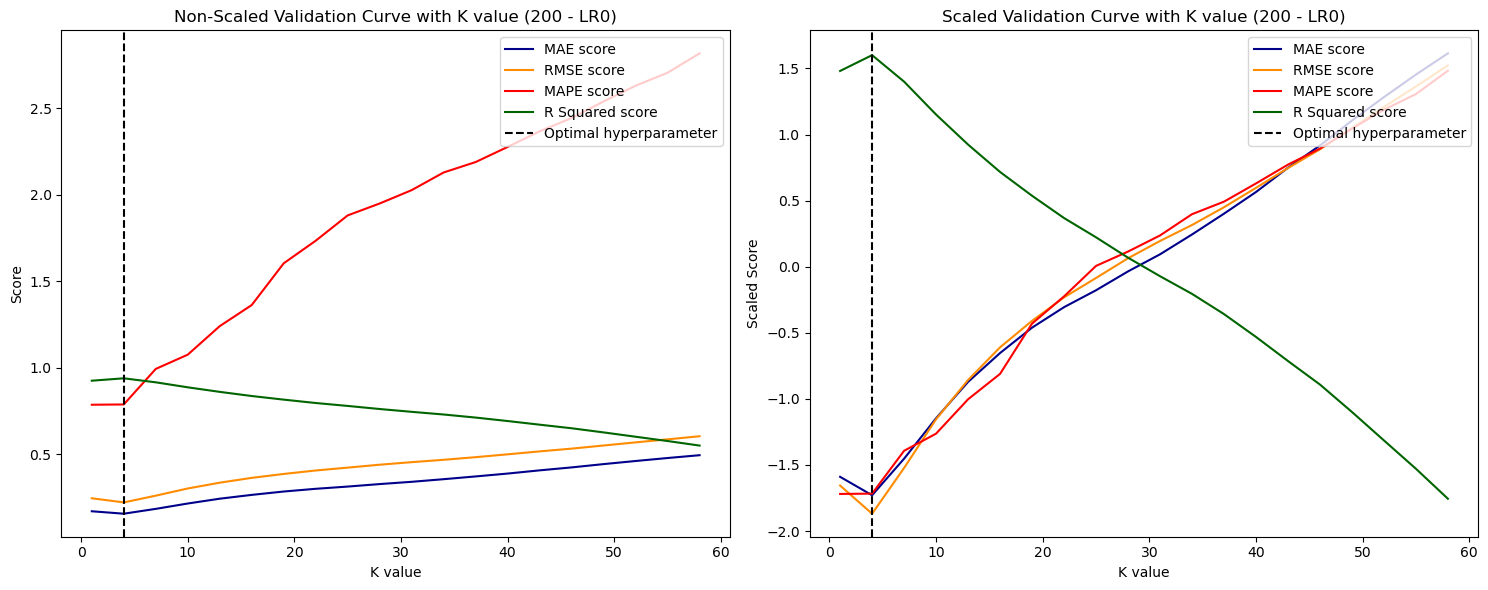

In [5]:
k = 4
df = pd.DataFrame(cv_score_list_200_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (200 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (200 - LR0)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [8]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal400.csv')

In [9]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.114547,0.106809,0.120330,0.138495,0.157879,0.178082,0.197248,0.216188,0.232126,0.246454,0.258271,0.270493,0.281536,0.291527,0.300194,0.308706,0.317030,0.324842,0.333467,0.341929
Validation Score RMSE,0.161289,0.150085,0.168301,0.190853,0.218836,0.246998,0.273217,0.297942,0.321000,0.342039,0.358831,0.374405,0.387995,0.400562,0.410957,0.420714,0.429967,0.438578,0.447541,0.456467
Validation Score MAPE,0.514557,0.419940,0.536808,0.661465,0.847325,0.985986,1.028413,1.128084,1.198221,1.279203,1.375285,1.437704,1.544388,1.638438,1.701436,1.734319,1.768283,1.833544,1.924966,1.968139
Validation Score R Squared,0.968036,0.972322,0.965196,0.955243,0.941157,0.925037,0.908278,0.890926,0.873390,0.856249,0.841789,0.827756,0.815026,0.802850,0.792484,0.782514,0.772842,0.763651,0.753892,0.743978


The smallest Validation Score MAE is 0.10680905690730591, found in K = 4.
The smallest Validation Score RMSE is 0.1500845589812304, found in K = 4.
The smallest Validation Score MAPE is 0.4199397190499782, found in K = 4.
The largest Validation Score R Squared is 0.9723222659472768, found in K = 4.
Validation Computation Time: 0.20 seconds


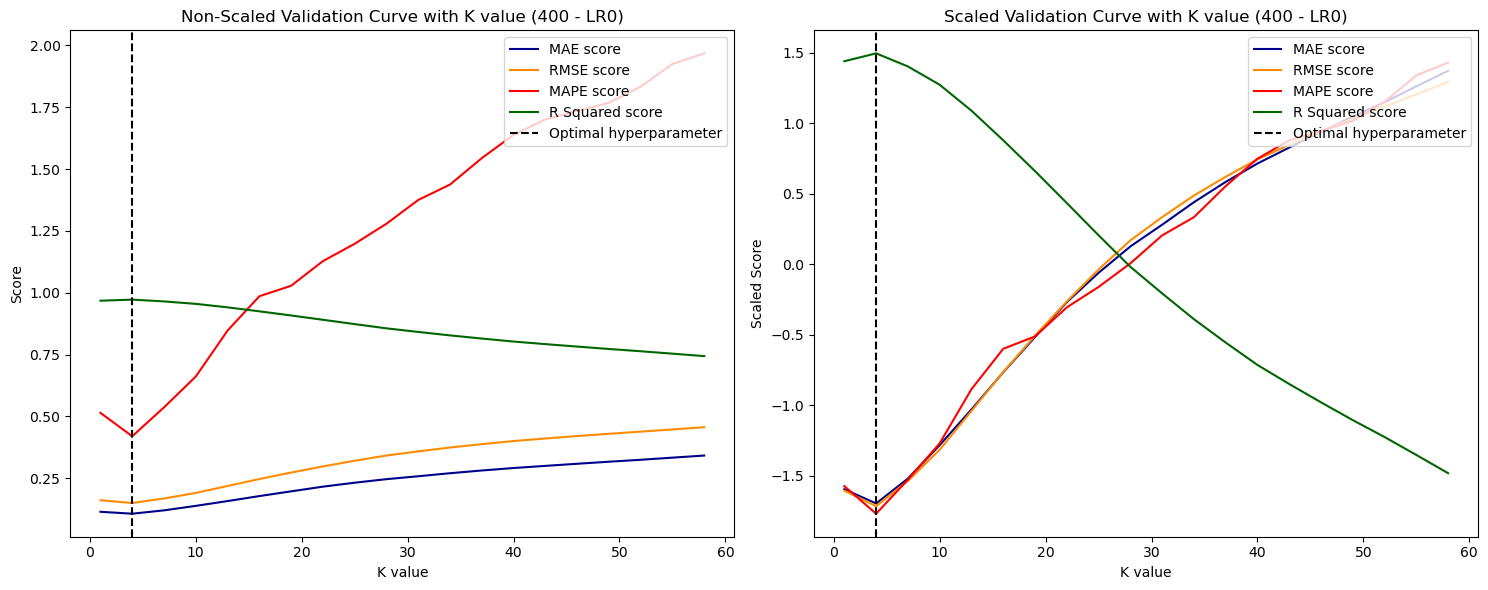

In [10]:
k = 4
df = pd.DataFrame(cv_score_list_400_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (400 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (400 - LR0)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [12]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal600.csv')

In [13]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.097242,0.085654,0.095531,0.110673,0.126285,0.140696,0.154892,0.167440,0.180929,0.193996,0.206929,0.218984,0.229921,0.239591,0.249782,0.258470,0.266593,0.274644,0.282222,0.288816
Validation Score RMSE,0.138821,0.125061,0.135390,0.151937,0.172992,0.192168,0.213530,0.232349,0.251096,0.268745,0.285286,0.301888,0.316356,0.330151,0.343876,0.356214,0.366633,0.376928,0.386340,0.394736
Validation Score MAPE,0.452918,0.462615,0.491704,0.564356,0.649226,0.780228,0.908046,1.005638,1.073440,1.176099,1.224490,1.278879,1.376115,1.386749,1.478686,1.558747,1.615933,1.679797,1.741808,1.787146
Validation Score R Squared,0.976321,0.980782,0.977477,0.971635,0.963228,0.954625,0.943976,0.933665,0.922529,0.911256,0.899996,0.888018,0.877027,0.866068,0.854701,0.844088,0.834833,0.825428,0.816600,0.808543


The smallest Validation Score MAE is 0.08565403804582102, found in K = 4.
The smallest Validation Score RMSE is 0.12506067994942394, found in K = 4.
The smallest Validation Score MAPE is 0.45291810957198614, found in K = 1.
The largest Validation Score R Squared is 0.9807823589908269, found in K = 4.
Validation Computation Time: 0.32 seconds


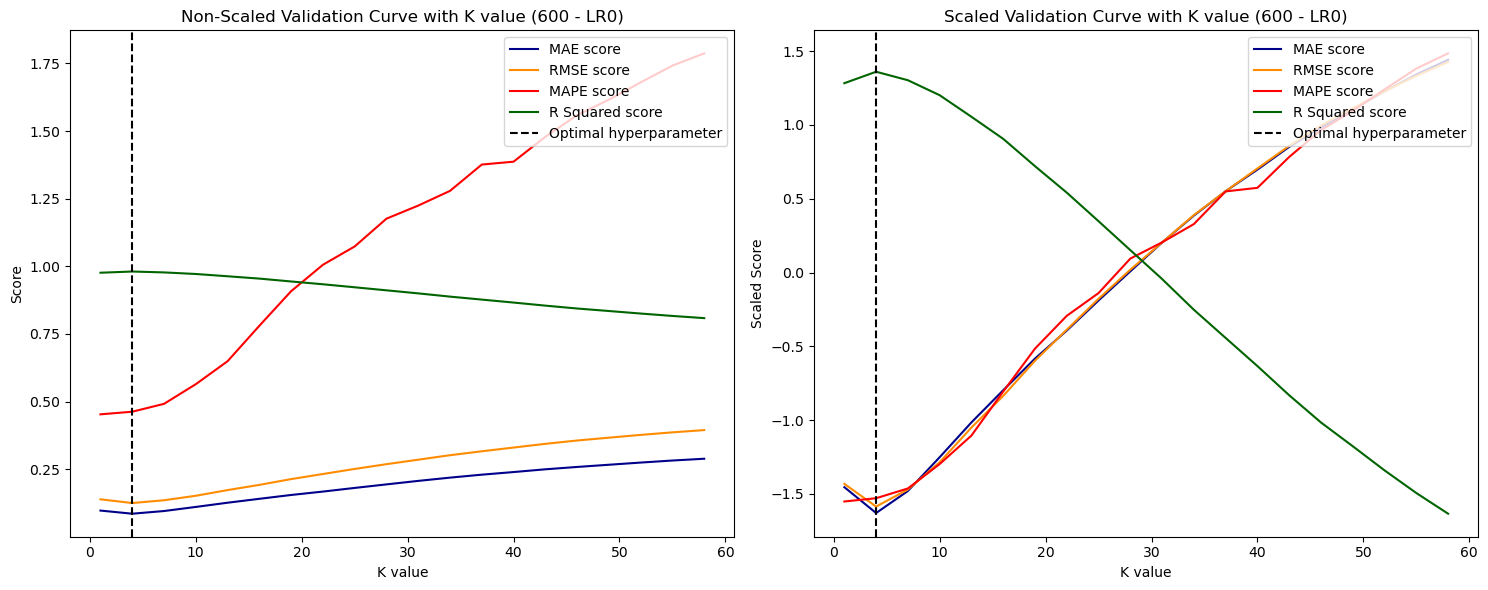

In [15]:
k = 4
df = pd.DataFrame(cv_score_list_600_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (600 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (600 - LR0)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [18]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal800.csv')

In [19]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.086052,0.072149,0.079510,0.089513,0.101683,0.112541,0.123887,0.136050,0.146418,0.158007,0.168799,0.178834,0.188527,0.198171,0.207836,0.215983,0.224190,0.231807,0.240021,0.247539
Validation Score RMSE,0.122986,0.108324,0.114764,0.126373,0.141188,0.155565,0.169852,0.186662,0.201580,0.216402,0.231193,0.244014,0.257949,0.270623,0.283410,0.293935,0.305191,0.315288,0.326047,0.336557
Validation Score MAPE,0.369078,0.376749,0.393641,0.430551,0.469966,0.513582,0.593443,0.759063,0.806217,0.920735,0.997150,0.998972,1.070714,1.141543,1.203109,1.260882,1.293876,1.314832,1.360138,1.427006
Validation Score R Squared,0.981415,0.985582,0.983817,0.980377,0.975506,0.970264,0.964551,0.957187,0.950071,0.942459,0.934324,0.926838,0.918243,0.910011,0.901307,0.893840,0.885553,0.877855,0.869377,0.860821


The smallest Validation Score MAE is 0.07214858457273847, found in K = 4.
The smallest Validation Score RMSE is 0.10832404652464346, found in K = 4.
The smallest Validation Score MAPE is 0.3690781081949702, found in K = 1.
The largest Validation Score R Squared is 0.9855818926323576, found in K = 4.
Validation Computation Time: 0.23 seconds


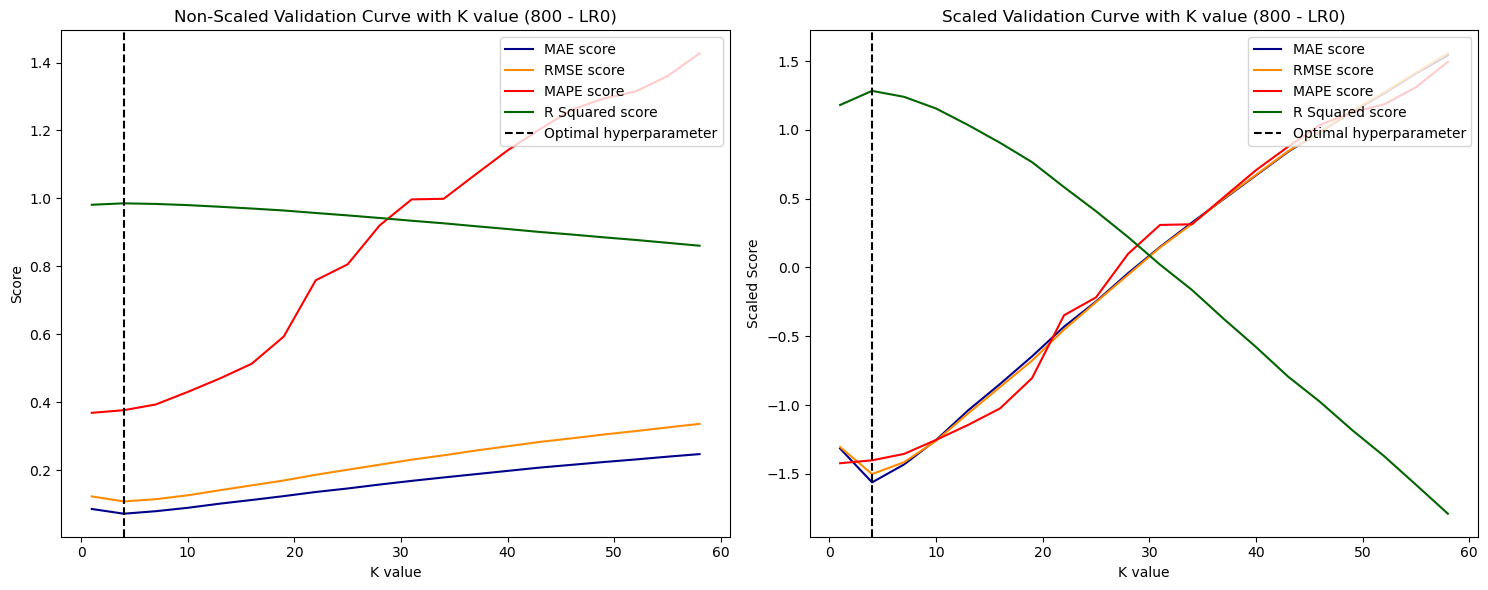

In [21]:
k = 4
df = pd.DataFrame(cv_score_list_800_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (800 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (800 - LR0)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [22]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal1000.csv')

In [23]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.076765,0.061831,0.067417,0.076065,0.085201,0.095430,0.105063,0.114750,0.123721,0.133196,0.142536,0.151378,0.160183,0.168145,0.176227,0.183896,0.191550,0.199292,0.206395,0.212698
Validation Score RMSE,0.107107,0.090885,0.096282,0.106032,0.117236,0.130471,0.143879,0.156397,0.168687,0.182167,0.194621,0.206255,0.217582,0.228421,0.238957,0.249695,0.260274,0.270707,0.280945,0.289589
Validation Score MAPE,0.341765,0.351275,0.328244,0.359467,0.384512,0.437807,0.468233,0.530282,0.609741,0.716115,0.779678,0.847910,0.896631,0.961306,1.001929,1.038262,1.064422,1.122187,1.174142,1.214695
Validation Score R Squared,0.985904,0.989851,0.988609,0.986186,0.983112,0.979084,0.974564,0.969945,0.965036,0.959225,0.953459,0.947728,0.941829,0.935889,0.929839,0.923391,0.916762,0.909956,0.903016,0.896956


The smallest Validation Score MAE is 0.06183133903508124, found in K = 4.
The smallest Validation Score RMSE is 0.09088451289383208, found in K = 4.
The smallest Validation Score MAPE is 0.3282443216289218, found in K = 7.
The largest Validation Score R Squared is 0.9898506489806914, found in K = 4.
Validation Computation Time: 0.22 seconds


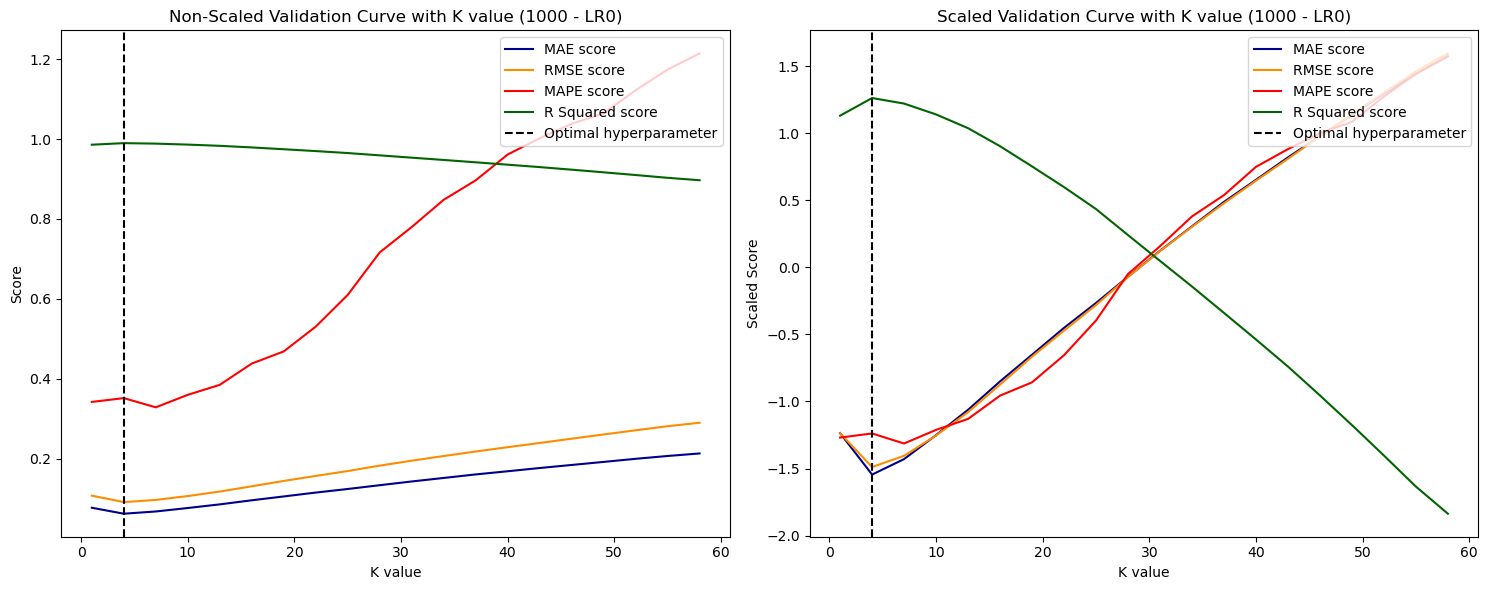

In [24]:
k = 4
df = pd.DataFrame(cv_score_list_1000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1000 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1000 - LR0)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [25]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal1500.csv')

In [26]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1500_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.065796,0.050377,0.052945,0.057993,0.064605,0.071466,0.077869,0.085818,0.091833,0.098480,0.105552,0.112086,0.118763,0.124882,0.131208,0.137198,0.143199,0.149122,0.155099,0.161001
Validation Score RMSE,0.088601,0.074754,0.078997,0.085511,0.091546,0.100237,0.108636,0.118645,0.126637,0.134919,0.143812,0.151768,0.160199,0.168137,0.176184,0.184441,0.192060,0.199253,0.206684,0.214122
Validation Score MAPE,0.306254,0.276172,0.319678,0.300275,0.314280,0.378923,0.356178,0.389514,0.449013,0.471678,0.483725,0.527606,0.578504,0.617841,0.694500,0.726376,0.768448,0.801062,0.843636,0.860693
Validation Score R Squared,0.990354,0.993134,0.992332,0.991015,0.989702,0.987654,0.985499,0.982703,0.980295,0.977633,0.974587,0.971698,0.968466,0.965263,0.961859,0.958200,0.954676,0.951217,0.947510,0.943665


The smallest Validation Score MAE is 0.050376998606132255, found in K = 4.
The smallest Validation Score RMSE is 0.07475362163037584, found in K = 4.
The smallest Validation Score MAPE is 0.2761715349004153, found in K = 4.
The largest Validation Score R Squared is 0.993133696732366, found in K = 4.
Validation Computation Time: 0.26 seconds


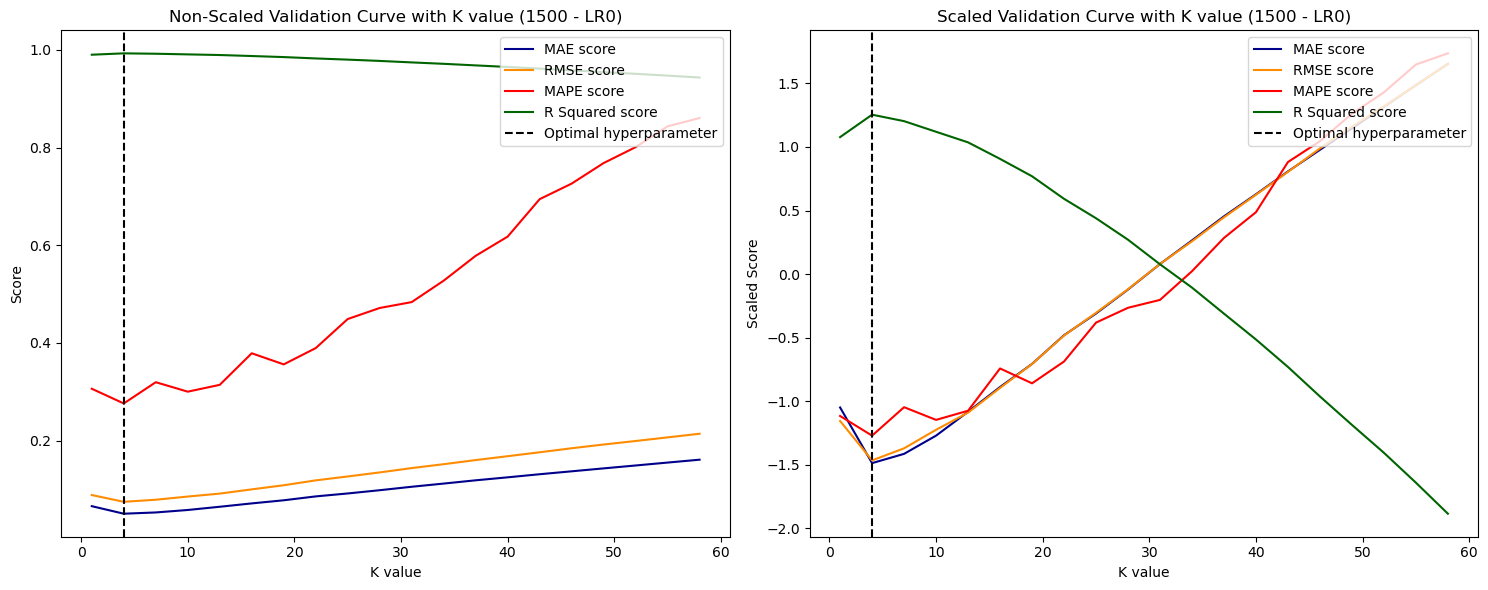

In [27]:
k = 4
df = pd.DataFrame(cv_score_list_1500_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1500 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1500 - LR0)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [28]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR0_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_LR0_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_LR0_input_randomfield_cal2000.csv')

In [29]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_2000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.058357,0.041823,0.042640,0.046388,0.051268,0.056743,0.061195,0.065576,0.070868,0.077262,0.083212,0.088594,0.094024,0.099510,0.105221,0.109979,0.114658,0.120002,0.124776,0.129792
Validation Score RMSE,0.077243,0.059839,0.061350,0.066438,0.073341,0.081027,0.086870,0.093623,0.100133,0.108001,0.115366,0.122115,0.128995,0.136024,0.143171,0.149703,0.155820,0.162534,0.168914,0.175338
Validation Score MAPE,0.242127,0.253581,0.273646,0.265817,0.298737,0.312870,0.298874,0.293340,0.309195,0.362419,0.406539,0.432815,0.448876,0.463237,0.491159,0.537729,0.579027,0.617096,0.669371,0.698790
Validation Score R Squared,0.992669,0.995600,0.995375,0.994576,0.993391,0.991933,0.990728,0.989230,0.987680,0.985668,0.983646,0.981677,0.979554,0.977265,0.974813,0.972463,0.970167,0.967540,0.964942,0.962225


The smallest Validation Score MAE is 0.041823272930558035, found in K = 4.
The smallest Validation Score RMSE is 0.05983873649624445, found in K = 4.
The smallest Validation Score MAPE is 0.24212695877352639, found in K = 1.
The largest Validation Score R Squared is 0.9956002972623492, found in K = 4.
Validation Computation Time: 0.44 seconds


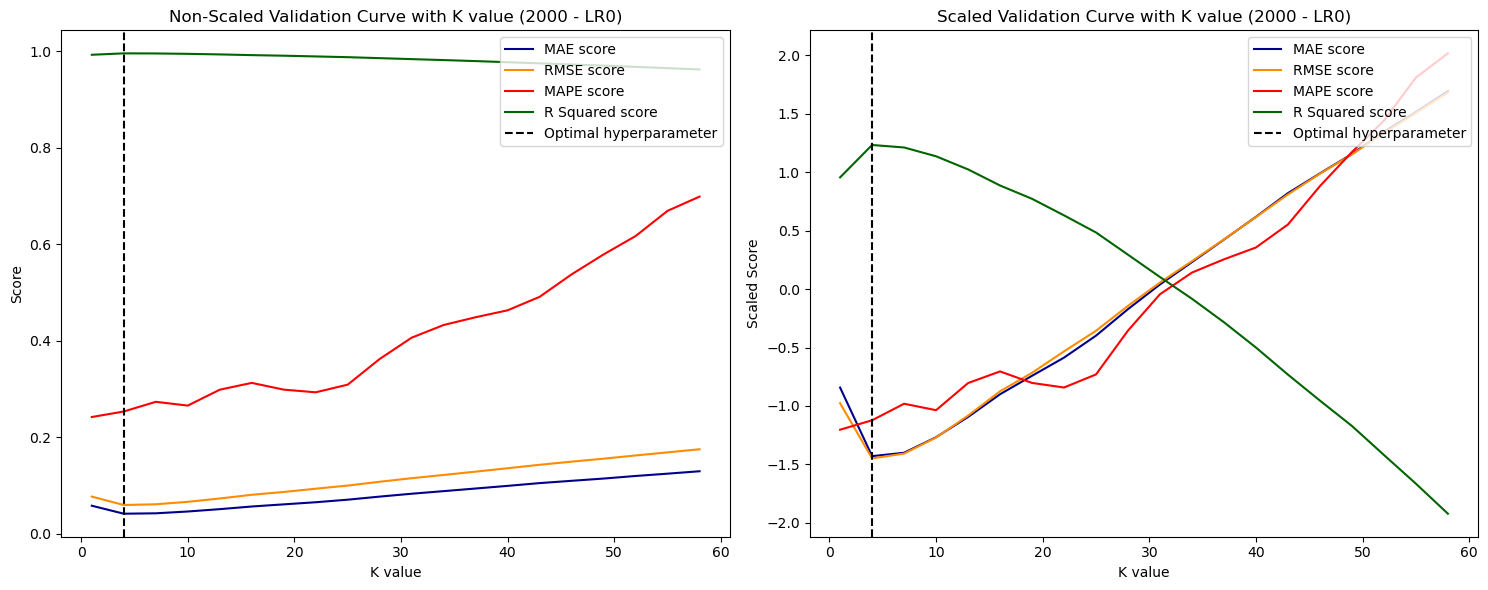

In [30]:
k = 4
df = pd.DataFrame(cv_score_list_2000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (2000 - LR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (2000 - LR0)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [31]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_k = [cv_score_list_200_k, cv_score_list_400_k, cv_score_list_600_k, cv_score_list_800_k,cv_score_list_1000_k,
                     cv_score_list_1500_k, cv_score_list_2000_k]

# Calculate means
all_means_k = calculate_means(data_structures_k)

In [32]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_k = replace_keys(all_means_k, new_keys)

In [33]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_k_df = pd.DataFrame(all_means_k).T
all_means_k_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.332059,0.433085,1.876181,0.753930
400,0.236808,0.324829,1.276325,0.857631
600,0.193464,0.267025,1.134631,0.902540
800,0.160376,0.220395,0.885062,0.933470
1000,0.136587,0.186809,0.731430,0.952017
1500,0.102765,0.140257,0.523218,0.973373
2000,0.082094,0.113292,0.412762,0.982557


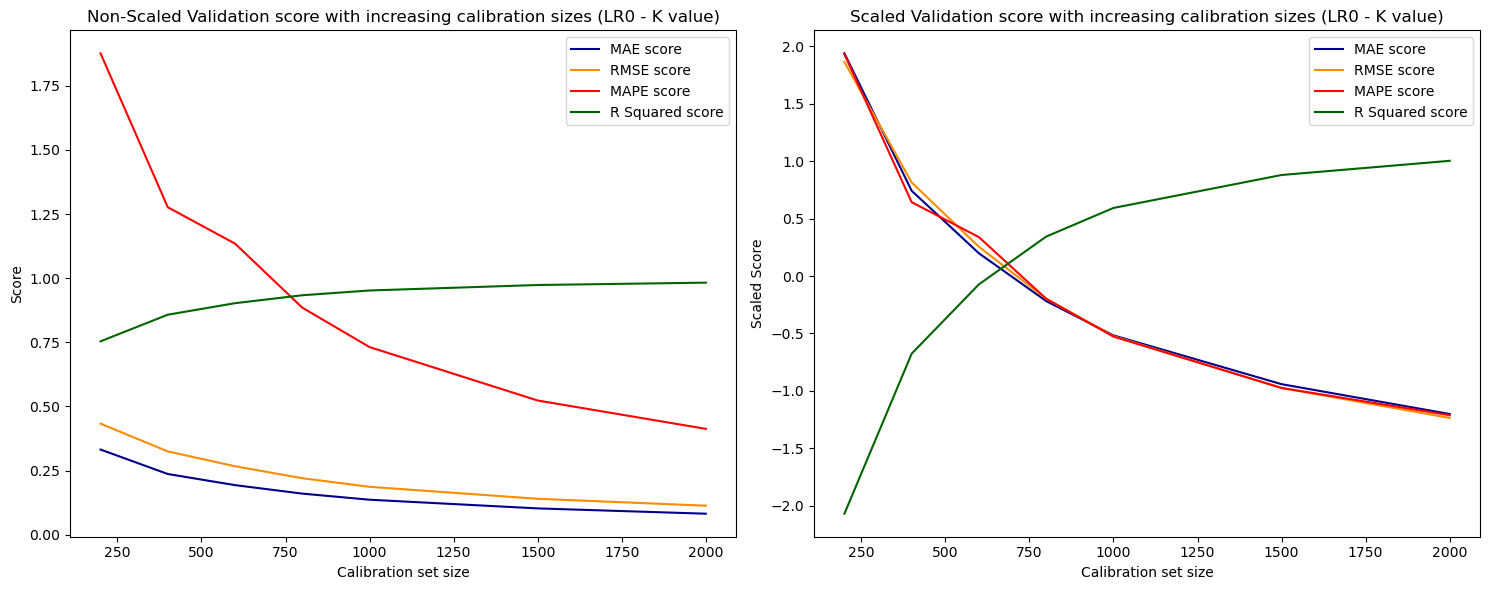

In [34]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_k_df), columns=all_means_k_df.columns, index=all_means_k_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_k_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (LR0 - K value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (LR0 - K value)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [35]:
filenames = ['LR0_input_randomfield_cal200','LR0_input_randomfield_cal400', 'LR0_input_randomfield_cal600',
             'LR0_input_randomfield_cal800', 'LR0_input_randomfield_cal1000', 'LR0_input_randomfield_cal1500', 'LR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/LR0/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-2.338943
1,47,42,-0.493586
2,92,88,-1.861865
3,24,43,-2.471080
4,37,92,-0.092991
...,...,...,...
3995,93,12,0.956064
3996,56,25,-0.197968
3997,22,8,-2.663248
3998,38,35,-1.180648


In [36]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

nn_model = KNeighborsRegressor(n_neighbors=4)
nn_model.fit(eval_combined_array_coordinates,combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = nn_model.predict(eval_combined_array_test)
    
rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.027309116876725107
RMSE: 0.03896017962517629
MAPE: 0.17923268044560245
R Squared: 0.998172666958705
Testing Computation Time: 0.08 seconds


### Plotting Spatial Interpolation of entire area with Model

In [37]:
filenames = ['cal_LR0_input_randomfield_cal200', 'cal_LR0_input_randomfield_cal400', 'cal_LR0_input_randomfield_cal600', 'cal_LR0_input_randomfield_cal800', 'cal_LR0_input_randomfield_cal1000', 'cal_LR0_input_randomfield_cal1500', 'cal_LR0_input_randomfield_cal2000',
            'val_LR0_input_randomfield_cal2000', 'test_LR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/LR0/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-0.829437
1,40,74,0.321811
2,90,28,-0.403227
3,51,84,0.128530
4,32,48,-1.498193
...,...,...,...
5995,93,12,0.956064
5996,56,25,-0.197968
5997,22,8,-2.663248
5998,38,35,-1.180648


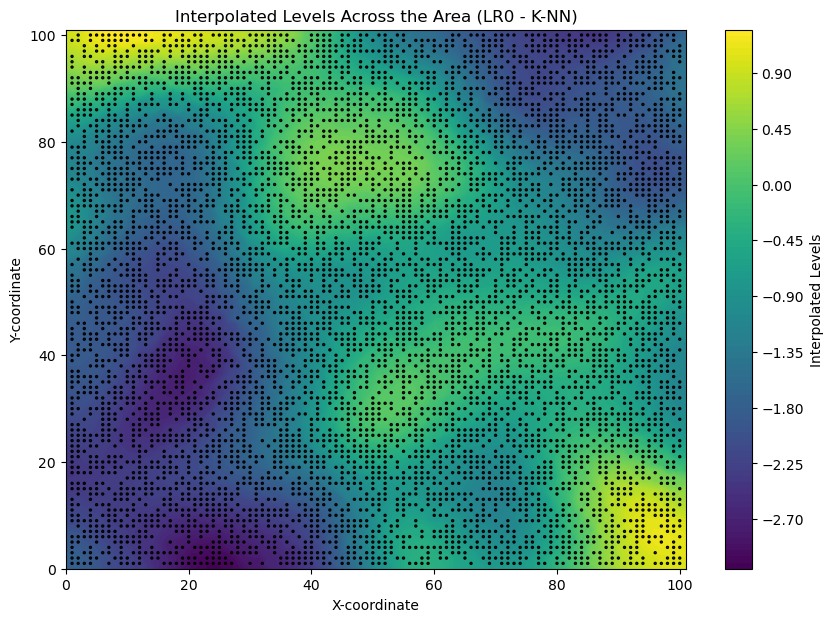

Spatial Interpolation Computation Time: 0.03 seconds


In [38]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
nn_model = KNeighborsRegressor(n_neighbors=4)
nn_model.fit(observed_locations,observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = nn_model.predict(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (LR0 - K-NN)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")